In [35]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import hcptrt_data_preparation
import seaborn as sn
from collections import Counter, defaultdict
from load_confounds import Params9, Params24
from nilearn.input_data import NiftiLabelsMasker
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score, train_test_split
from sklearn.svm import SVC
from numpy import savetxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [2]:
TR = 1.49
subject = 'sub-01'
modality = 'wm'
confounds = Params9()

# event_suffix = '{}_ses-001_task-restingstate_run-01_events.tsv'.format()
out_path = '/home/SRastegarnia/hcptrt_decoding_Shima/hcptrt_decoding/'\
            'timeseries_benchmark/outputs_check/'
bold_suffix = 'space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

data_path = sorted(glob.glob('/data/neuromod/DATA/cneuromod/hcptrt/derivatives/'\
                     'fmriprep-20.2lts/fmriprep/{}/**/*{}*'
                     .format(subject, modality) + bold_suffix, recursive=True))

events_path = sorted(glob.glob('/data/neuromod/DATA/cneuromod/hcptrt/'\
                     '{}/**/func/*{}*_events.tsv'
                     .format(subject, modality), recursive=True))

In [3]:
# Done!
# def load_fmri_data(subject, modality, confounds): 

print('The number of bold files:', len(data_path))

bold_files = []
for dpath in data_path:    
    masker = NiftiLabelsMasker(labels_img = 'MIST_444.nii.gz', standardize=True, 
                              detrend = False, smoothing_fwhm = 5).fit()
    data_fmri = masker.transform(dpath, confounds = confounds.load(dpath))    
    bold_files.append(data_fmri)

bold_outname = out_path + modality + '_fMRI2.npy'
np.save(bold_outname, bold_files)
print('######### Reading Nifiti files is done! #########')  

The number of bold files: 15
######### Reading Nifiti files is done! #########


In [4]:
a = np.load(bold_outname, allow_pickle=True)
print(np.shape(a))

(15, 202, 444)


In [5]:
# Done!
# def load_events_files(events_path, modality)

print('The number of events files:', len(events_path))

events_files = []
for epath in events_path: 
    event = pd.read_csv(epath, sep = "\t", encoding = "utf8", header = 0)
    if modality == 'wm':                    
        event.trial_type = event.trial_type.astype(str) + '_' + \
        event.stim_type.astype(str)
        
    if modality == 'relational':                    
        event.trial_type = event.trial_type.astype(str) + '_' + \
        event.instruction.astype(str)

    events_files.append(event)

print('######### Reading events files is done! #########') 

The number of events files: 15
######### Reading events files is done! #########


In [6]:
## bold_outname = '/home/SRastegarnia/hcptrt_decoding_Shima/hcptrt_decoding/'\
##                  'timeseries_benchmark/outputs/motor_fMRI2.npy'

# # np.save(bold_outname, bold_files)
# print(bold_outname)
# a = np.load(bold_outname, allow_pickle=True)
# print(np.shape(a))
# print(np.shape(a[0]))
# print(len(a))
# print(bold_files[0].shape)

# print(events_files[0])
# print(len(events_files))

In [7]:
# Done!
# def check_input(bold_files, events_files):

data_lenght = len(bold_files)
data_lenght = int (data_lenght or 0)

for i in range(0, data_lenght-1):
    if bold_files[i].shape > bold_files[i+1].shape:         
        a = np.shape(bold_files[i])[0] - np.shape(bold_files[i+1])[0]        
        bold_files[i] = bold_files[i][0:-a, 0:]
        print('The bold file number', i, 'had', a, 'extra volumes')

if len(events_files) != len(bold_files):
    print('Miss-matching between events and fmri files')
    print('Number of Nifti files:' ,len(bold_files))
    print('Number of events files:' ,len(events_files)) 
    
for d in range(0, data_lenght-1):
    if bold_files[d].shape != bold_files[d].shape:
        print('There is mismatch in BOLD file size!')

# Generating labels files for all the events

In [8]:
# Done!
# def volume_labeling(bold_files, events_files, confounds, subject, modality):

labels_files = []
for events_file in events_files:
    task_durations = []
    task_modalities = []
    row_counter = 0

    task_modalities.append(events_file.iloc[0]['trial_type'])
    rows_no = len(events_file.axes[0])
#     cols_no = len(events_file.axes[1])

    for i in range(1, rows_no):
        if (events_file.iloc[i]['trial_type'] != events_file.iloc[i-1]['trial_type']):
            task_modalities.append(events_file.iloc[i]['trial_type'])
            duration = (events_file.iloc[i]['onset']) - \
                        (events_file.iloc[row_counter]['onset'])
            task_durations.append(duration)
            row_counter = i
            
    # Adds the last tcondition (cross_fixation)
    task_durations.append(events_file.iloc[i]['duration'])

    if (len(task_durations) != len(task_modalities)):
        print('error: tasks and durations do not match')

    task_durations = np.array(task_durations)
    task_modalities = np.array(task_modalities)

    # Generate volume No. array for each task condition
    volume_no = []
    for t in task_durations:
        volume_round = np.round((t)/TR).astype(int)
        volume_no.append(volume_round)

    # Find the Qty of null ending volumes
    def _sum(arr): 
        sum = 0
        for i in arr:
            sum = sum + i
        return(sum) 

    ans_round = _sum(volume_no)
    sample_fmri = masker.transform(data_path[0], confounds = confound_name.
                                 load(data_path[0]))
    null_ending = sample_fmri.shape[0] - ans_round 
    
    # Generate timeseries labels considering the volume No.           
    final_array = []
    if (len(task_modalities) == len(task_durations) == len(volume_no)):
        for l in range (len(task_modalities)):
            f = ((task_modalities[l],) * volume_no[l])
            final_array.append(f)
    
    # Add the null label for the ending volumes
    if null_ending > 0:
        end_volume = (('null',) * null_ending)
        final_array.append(end_volume)
    
    # Generate a flat list of labels
    flat_list = [item for sublist in final_array for item in sublist]
    volume_labels = np.array(flat_list)  
    labels_files.append(volume_labels)

# Generate a flat list of labels
flat_labels_files = [item for sublist in labels_files for item in sublist]
flat_volume_labels = np.array(flat_labels_files)

shape = np.shape(bold_files[1])[0]
flat_volume_labels = np.reshape(flat_volume_labels, (data_lenght * shape,1))

# Generate a flat list of bold matrices
flat_bold = [item for sublist in bold_files for item in sublist]
flat_bold_files = np.array(flat_bold)  

# Cheking the same lenght of the flat bold and label file
if (len(flat_bold_files[:, 0]) != len(flat_volume_labels[:, 0])):
    print('error: labels and bold flat files mismatche')

In [9]:
# def HRFlag_labeling(flat_volume_labels)

# Labeling the 3 first volumes of stimulus longer than 5 seconds as HRF_lag
HRFlag_volume_labels = []
b = 0
l = len(flat_volume_labels[:, 0]) 

while (b < (l- 1)):  
    if (flat_volume_labels[b, 0] != flat_volume_labels[b + 1, 0]):
        HRFlag_volume_labels.append(flat_volume_labels[b, 0])

        if (flat_volume_labels[b + 1, 0] == flat_volume_labels[b + 2, 0] == 
            flat_volume_labels[b + 3, 0] == flat_volume_labels[b + 4, 0]):
            for j in range (1, 4):
                HRFlag_volume_labels.append('HRF_lag')
            b = b + 4  
        else:
            b = b + 1
            
    else:
        HRFlag_volume_labels.append(flat_volume_labels[b, 0])
        b = b + 1

HRFlag_volume_labels.append(flat_volume_labels[l - 1, 0])
# HRFlag_volume_labels = np.reshape(HRFlag_volume_labels, (data_lenght*sh,1))

# print(len(HRFlag_volume_labels))
# for i in range (2000, 2159):
#     print(HRFlag_volume_labels[i], ': ', flat_volume_labels[i, 0]) 

# print(np.shape(flat_volume_labels))
# print(np.shape(HRFlag_volume_labels))

In [10]:
categories = list(events_files[0].trial_type)
unwanted = {'countdown','cross_fixation','Cue','new_bloc_right_hand', 
            'new_bloc_right_foot','new_bloc_left_foot','new_bloc_tongue', 
            'new_bloc_left_hand','new_bloc_control','new_bloc_relational',
            'new_bloc_shape','new_bloc_face', 'countdown_nan','Cue_nan', 'HRF_lag', 'null'
            }
categories = [c for c in categories if c not in unwanted]
conditions = list(set(categories))
num_cond = len(set(categories))
# print(num_cond)
# print(conditions)

In [11]:
final_volume_labels = []
parcel_no = np.shape(flat_bold_files[1])[0]
final_bold_files = np.empty((0, parcel_no), int)

for i in range (0, len(HRFlag_volume_labels)):
    if (HRFlag_volume_labels[i] not in unwanted):
        final_volume_labels.append(HRFlag_volume_labels[i])
        final_bold_files = np.append(final_bold_files, 
                                     np.array([flat_bold_files[i, :]]), axis=0)

In [12]:
df_lable = pd.DataFrame(final_volume_labels)
df_lable.to_csv(out_path + modality +'_final_labels.csv', sep=',' ,index=False, header=None)

df_fMRI = out_path + modality + '_final_fMRI.npy'
np.save(df_fMRI, final_bold_files)

In [37]:
print('parcel numbers:', parcel_no)
print('lenght of all volume labels:', len(HRFlag_volume_labels))
print('shape of flat_bold_files:', np.shape(flat_bold_files))
print(type(final_bold_files))
print('lenght of final_volume_labels:', len(final_volume_labels))
print(type(final_volume_labels))
print('lenght of final_bold_files:', len(final_bold_files))
print('shape of final_bold_files:', np.shape(final_bold_files))
print('shape of final_volume_labels:', np.shape(final_volume_labels))
print('number of data files:', data_lenght)
print(np.shape(bold_files[1])[0])
print(data_lenght*(np.shape(bold_files[1])[0]))
# print(final_volume_labels)
# print(final_bold_files)

parcel numbers: 444
lenght of all volume labels: 3030
shape of flat_bold_files: (3030, 444)
<class 'numpy.ndarray'>
lenght of final_volume_labels: 2037
<class 'list'>
lenght of final_bold_files: 2037
shape of final_bold_files: (2037, 444)
shape of final_volume_labels: (2037,)
number of data files: 15
202
3030


# ANN Decoding

In [42]:
# dl = data_lenght
# sh = np.shape(bold_files[1])[0]

# Data selection
X = final_bold_files
y = final_volume_labels

# Find unique conditions
categories = np.unique(y)
unique_conditions, order = np.unique(categories, return_index=True)
unique_conditions = unique_conditions[np.argsort(order)]

# Encoding the string to numerical values
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

# Reshape y
temp = np.reshape(y, (len(final_volume_labels),1))
y = temp

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
y = pd.DataFrame(enc.fit_transform(y).toarray())
print('label encoded values:', y)

# shuffle and split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

#standarize features caling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label encoded values:         0    1    2    3    4    5    6    7
0     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...
2032  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2033  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2034  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2035  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
2036  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0

[2037 rows x 8 columns]


In [43]:
# print(X_train)
# print(np.shape(X_train))
# print(type(X_train))

# print(y_train)
# print(type(y_train))
# print(np.shape(y))

# print(X_test)
# print(np.shape(X_test))
# print(type(X_test))

# print(y_test)
# print(type(y_test))

In [44]:
# Initializing the ANN
warnings.filterwarnings('ignore')
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(222 , input_dim = 444, activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(111, activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(55, activation = 'relu'))

classifier.add(Dense(num_cond, activation = 'softmax'))
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 222)               98790     
_________________________________________________________________
dense_5 (Dense)              (None, 111)               24753     
_________________________________________________________________
dense_6 (Dense)              (None, 55)                6160      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 448       
Total params: 130,151
Trainable params: 130,151
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

# # Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, batch_size = 5, epochs = 5, 
                         validation_split = 0.1)

# # Fitting the ANN to the Training set
# history.classifier.fit(X_train, y_train, batch_size = 5, epochs = 10, validation_split = 0.1)

Epoch 1/5
330/330 [==============================] - 3s 6ms/step - loss: 1.7899 - accuracy: 0.3439 - val_loss: 1.1697 - val_accuracy: 0.5815
Epoch 2/5
330/330 [==============================] - 2s 5ms/step - loss: 0.8197 - accuracy: 0.7235 - val_loss: 0.8745 - val_accuracy: 0.6957
Epoch 3/5
330/330 [==============================] - 2s 5ms/step - loss: 0.4346 - accuracy: 0.8566 - val_loss: 1.0010 - val_accuracy: 0.7011
Epoch 4/5
330/330 [==============================] - 2s 5ms/step - loss: 0.2720 - accuracy: 0.9088 - val_loss: 0.8557 - val_accuracy: 0.7120
Epoch 5/5
330/330 [==============================] - 2s 5ms/step - loss: 0.1729 - accuracy: 0.9456 - val_loss: 1.1454 - val_accuracy: 0.7174


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


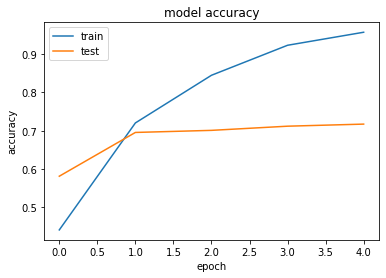

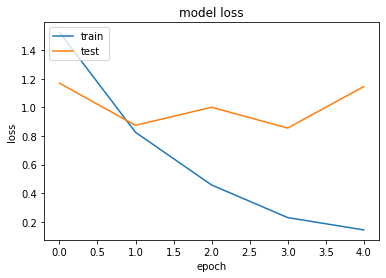

In [46]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# Making the predictions and evaluating the model
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis=1))

# normalising confusion matrix
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
# print(np.round(cmn, 2))

Text(133.9737500000001, 0.5, 'predicted label')

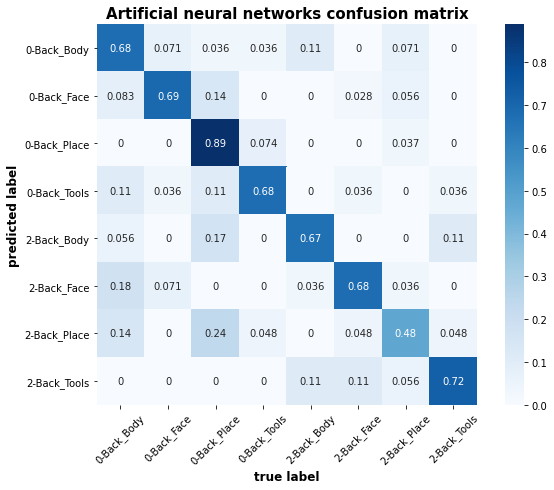

In [27]:
import seaborn as sn

df_cm = pd.DataFrame(cmn, index=unique_conditions, columns=unique_conditions)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', square=True)
plt.xticks(rotation = 45)
plt.title('Artificial neural networks confusion matrix', fontsize=15, fontweight='bold')
plt.xlabel("true label", fontsize= 12, fontweight='bold')
plt.ylabel("predicted label", fontsize=12, fontweight='bold')

# SVC Decoding

In [28]:
# Data selection
X = final_bold_files
y = final_volume_labels

#shuffle and split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#standarize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing the SVM
model_svm = SVC(C = 1.0, cache_size = 200, class_weight = None, coef0 = 0.0,
    decision_function_shape = 'ovo', degree = 3, gamma = 'scale', kernel = 'linear',
    max_iter = -1, probability = False, random_state = None, shrinking = True,
    tol = 0.001, verbose = False)

model_svm.fit(X_train, y_train)

#accuracy
score = model_svm.score(X_test, y_test)

#print classification report
svm = model_svm.predict(X_test)
report = classification_report(y_test, svm)
print(report)

print("Test score with L1 penalty: %.4f" % score)

              precision    recall  f1-score   support

 0-Back_Body       0.58      0.74      0.65        34
 0-Back_Face       0.58      0.66      0.61        29
0-Back_Place       0.47      0.45      0.46        20
0-Back_Tools       0.59      0.56      0.57        18
 2-Back_Body       0.67      0.76      0.71        21
 2-Back_Face       0.77      0.59      0.67        34
2-Back_Place       0.50      0.39      0.44        31
2-Back_Tools       0.67      0.71      0.69        17

    accuracy                           0.60       204
   macro avg       0.60      0.60      0.60       204
weighted avg       0.61      0.60      0.60       204

Test score with L1 penalty: 0.6029


In [29]:
# Cross validation
cv_scores_svm  = cross_val_score(model_svm , X_train, y_train, cv=5) 
print(cv_scores_svm)

# The mean prediction accuracy
classification_accuracy_svm  = np.mean(cv_scores_svm )
classification_accuracy_svm

[0.58038147 0.5613079  0.5613079  0.56284153 0.55737705]


0.5646431708878664

Text(133.9737500000001, 0.5, 'predicted labels')

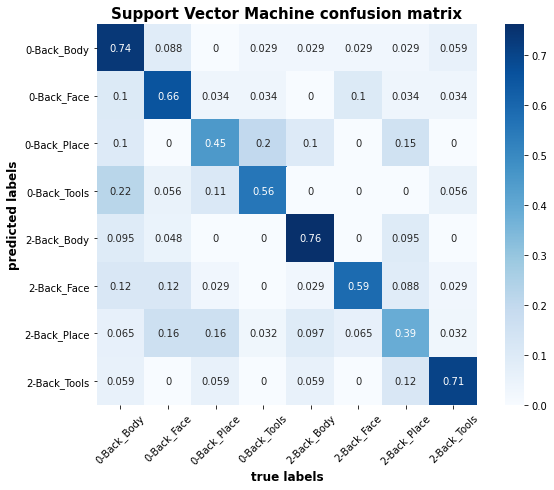

In [38]:
# confusion matrix
cm_svm = confusion_matrix(y_test, svm)
cmn_svm = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]
title = 'Support Vector Machine confusion matrix'
df_cm = pd.DataFrame(cmn_svm, index=unique_conditions, columns=unique_conditions)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', square=True)
plt.xticks(rotation = 45)
plt.title(title, fontsize=15, fontweight='bold')
plt.xlabel("true labels", fontsize= 12, fontweight='bold')
plt.ylabel("predicted labels", fontsize=12, fontweight='bold')

# Neural Networks Decoding

In [31]:
# Initializing the NN
model_nn = MLPClassifier(activation='logistic', alpha=1e-5, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(5, 2),
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              solver='lbfgs', tol=0.0001, validation_fraction=0.1, 
              verbose=False, warm_start=False)

#train model
model_nn.fit(X_train, y_train)

#accuracy
score = model_nn.score(X_test, y_test)

#print classification report
nn = model_nn.predict(X_test)
report = classification_report(y_test, nn)
print(report)

print("Test score with L1 penalty: %.4f" % score)

              precision    recall  f1-score   support

 0-Back_Body       0.58      0.41      0.48        34
 0-Back_Face       0.27      0.24      0.25        29
0-Back_Place       0.39      0.35      0.37        20
0-Back_Tools       0.46      0.67      0.55        18
 2-Back_Body       0.59      0.62      0.60        21
 2-Back_Face       0.63      0.65      0.64        34
2-Back_Place       0.30      0.29      0.30        31
2-Back_Tools       0.30      0.41      0.35        17

    accuracy                           0.45       204
   macro avg       0.44      0.45      0.44       204
weighted avg       0.45      0.45      0.44       204

Test score with L1 penalty: 0.4461


In [32]:
# Cross validation
cv_scores_nn = cross_val_score(model_nn, X_train, y_train, cv=5) 
print(cv_scores_nn)

# The mean prediction accuracy
classification_accuracy_nn = np.mean(cv_scores_nn)
classification_accuracy_nn

[0.40871935 0.41144414 0.36784741 0.40983607 0.41256831]


0.40208305415345214

In [33]:
prediction_accuracy_nn = cv_scores_nn * 100
print(prediction_accuracy_nn)

[40.8719346  41.14441417 36.78474114 40.98360656 41.2568306 ]


Text(133.9737500000001, 0.5, 'predicted labels')

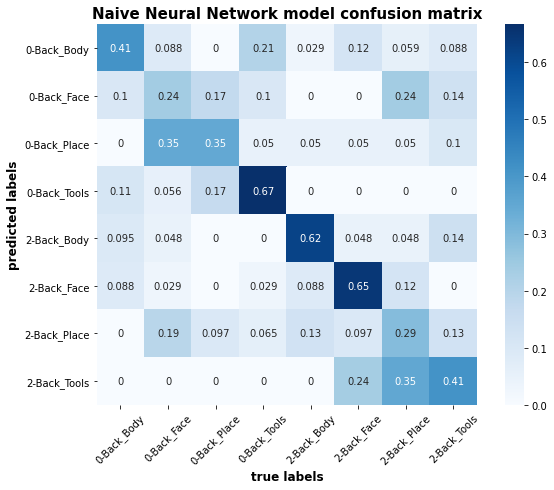

In [39]:
# confusion matrix
cm_nn = confusion_matrix(y_test, nn)
cmn_nn = cm_nn.astype('float') / cm_nn.sum(axis=1)[:, np.newaxis]
title = 'Naive Neural Network model confusion matrix'
df_cm = pd.DataFrame(cmn_nn, index=unique_conditions, columns=unique_conditions)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', square=True)
plt.xticks(rotation = 45)
plt.title(title, fontsize=15, fontweight='bold')
plt.xlabel("true labels", fontsize= 12, fontweight='bold')
plt.ylabel("predicted labels", fontsize=12, fontweight='bold')